Data Selection

In [54]:
import pandas as pd

data = pd.read_csv('jabodetabek_house_price.csv')
data.info()

relevant_columns = ['price_in_rp', 'land_size_m2', 'building_size_m2', 'bedrooms', 'bathrooms', 'district', 'city', 'facilities']
data_selected = data[relevant_columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3553 entries, 0 to 3552
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   url                   3553 non-null   object 
 1   price_in_rp           3553 non-null   float64
 2   title                 3553 non-null   object 
 3   address               3553 non-null   object 
 4   district              3553 non-null   object 
 5   city                  3553 non-null   object 
 6   lat                   3553 non-null   float64
 7   long                  3553 non-null   float64
 8   facilities            3553 non-null   object 
 9   property_type         3552 non-null   object 
 10  ads_id                3549 non-null   object 
 11  bedrooms              3519 non-null   float64
 12  bathrooms             3524 non-null   float64
 13  land_size_m2          3551 non-null   float64
 14  building_size_m2      3551 non-null   float64
 15  carports             

In [5]:

bins = [0, 1000000000, 5000000000, float('inf')]  # Rentang harga
labels = ['Murah', 'Menengah', 'Mewah']
data_selected['price_category'] = pd.cut(data_selected['price_in_rp'], bins=bins, labels=labels)


<ipython-input-5-cb866a283857>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_selected['price_category'] = pd.cut(data_selected['price_in_rp'], bins=bins, labels=labels)


In [56]:
dropped_df = data.drop(['url', 'title', 'address', 'district', 'city', 'ads_id', 'year_built', 'building_orientation', 'building_age'], axis=1)
dropped_df.info()

print(dropped_df.head())




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3553 entries, 0 to 3552
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   price_in_rp         3553 non-null   float64
 1   lat                 3553 non-null   float64
 2   long                3553 non-null   float64
 3   facilities          3553 non-null   object 
 4   property_type       3552 non-null   object 
 5   bedrooms            3519 non-null   float64
 6   bathrooms           3524 non-null   float64
 7   land_size_m2        3551 non-null   float64
 8   building_size_m2    3551 non-null   float64
 9   carports            3553 non-null   float64
 10  certificate         3412 non-null   object 
 11  electricity         3553 non-null   object 
 12  maid_bedrooms       3553 non-null   float64
 13  maid_bathrooms      3553 non-null   float64
 14  floors              3547 non-null   float64
 15  property_condition  3307 non-null   object 
 16  garage

Feature Engineering: Adding new features

In [17]:

data['age_of_house'] = 2024 - data['year_built']
data['price_per_sqm'] = data['price_in_rp'] / (data['land_size_m2'] + data['building_size_m2'])
data['land_building_interaction'] = data['land_size_m2'] * data['building_size_m2']


Use KNN imputer to fill missing values for relevant columns

In [18]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
data_imputed = imputer.fit_transform(data[['land_size_m2', 'building_size_m2', 'bedrooms', 'bathrooms', 'year_built']])
data[['land_size_m2', 'building_size_m2', 'bedrooms', 'bathrooms', 'year_built']] = data_imputed


Standardize features

In [19]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[['land_size_m2', 'building_size_m2', 'bedrooms', 'bathrooms', 'price_per_sqm', 'age_of_house', 'land_building_interaction']])


In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


X = data[['land_size_m2', 'building_size_m2', 'bedrooms', 'bathrooms', 'price_per_sqm', 'age_of_house', 'land_building_interaction']]
y = data['price_in_rp']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

y_pred_rf = model_rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f'Mean Squared Error (MSE) with Random Forest: {mse_rf}')


Mean Squared Error (MSE) with Random Forest: 6.230214577733662e+18



Hyperparameter tuning using GridSearchCV

In [21]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
print(f'Best Parameters: {grid_search.best_params_}')


Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}


 Cross-validation with Random Forest

In [22]:
from sklearn.model_selection import cross_val_score


cv_scores = cross_val_score(model_rf, X, y, cv=5, scoring='neg_mean_squared_error')
print(f'Cross-Validation MSE: {-cv_scores.mean()}')


Cross-Validation MSE: 1.2430602469560087e+20


In [25]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
base_learners = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('lr', LinearRegression())
]

X_train_clean = X_train.dropna()
y_train_clean = y_train[X_train_clean.index]

X_test_clean = X_test.dropna()
y_test_clean = y_test[X_test_clean.index]
stacking_model.fit(X_train_clean, y_train_clean)

y_pred_stack = stacking_model.predict(X_test_clean)
mse_stack = mean_squared_error(y_test_clean, y_pred_stack)
print(f'Mean Squared Error (MSE) with Stacking: {mse_stack}')

Mean Squared Error (MSE) with Stacking: 9.823476406499215e+18


In [26]:

feature_importance = model_rf.feature_importances_
for feature, importance in zip(X.columns, feature_importance):
    print(f'{feature}: {importance}')


land_size_m2: 0.023896906107040296
building_size_m2: 0.08966397437798945
bedrooms: 0.00592670135766055
bathrooms: 0.006821854231119741
price_per_sqm: 0.588096487039641
age_of_house: 0.0024775789223000985
land_building_interaction: 0.28311649796424887


Remove outliers using Z-score

In [27]:
from scipy import stats
z_scores = stats.zscore(data[['price_in_rp', 'land_size_m2', 'building_size_m2']])
data_no_outliers = data[(z_scores < 3).all(axis=1)]



Evaluate the R² score

In [28]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred_rf)
print(f'R² Score: {r2}')



R² Score: 0.9145831770128328


Residual plot

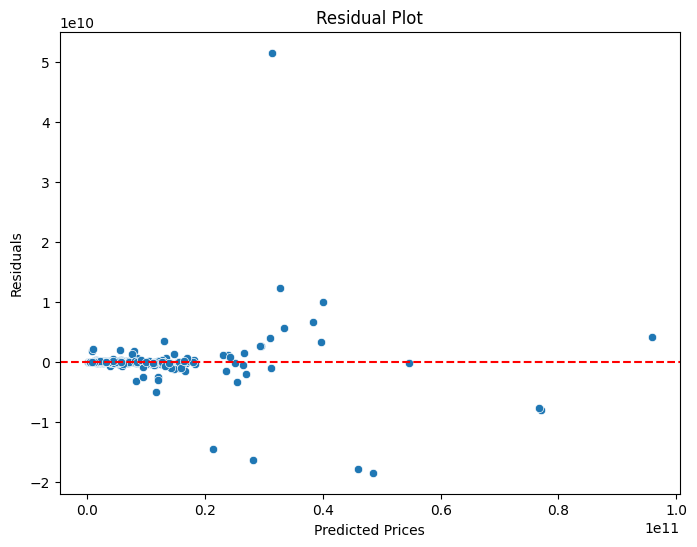

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns


residuals = y_test - y_pred_rf

# Residual plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred_rf, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Prices')
plt.ylabel('Residuals')
plt.show()


# Feature importance plot

Plot Actual vs Predicted

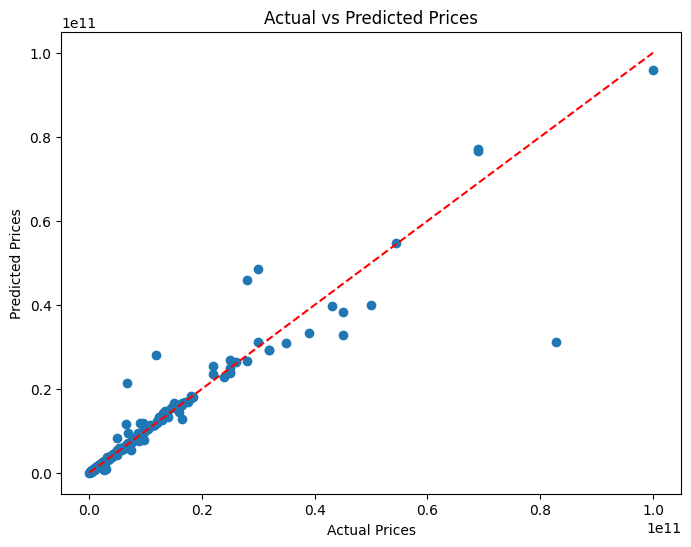

In [30]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.show()


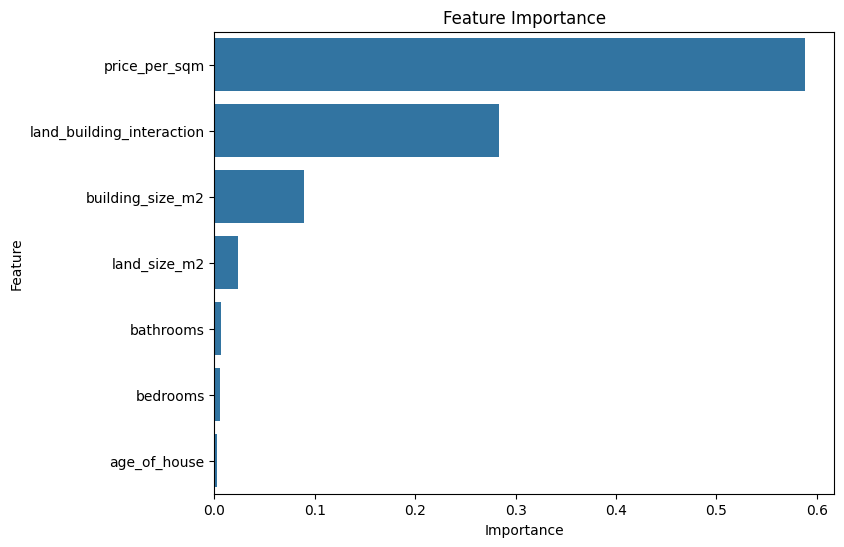

In [31]:

features = X.columns
importance = model_rf.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()


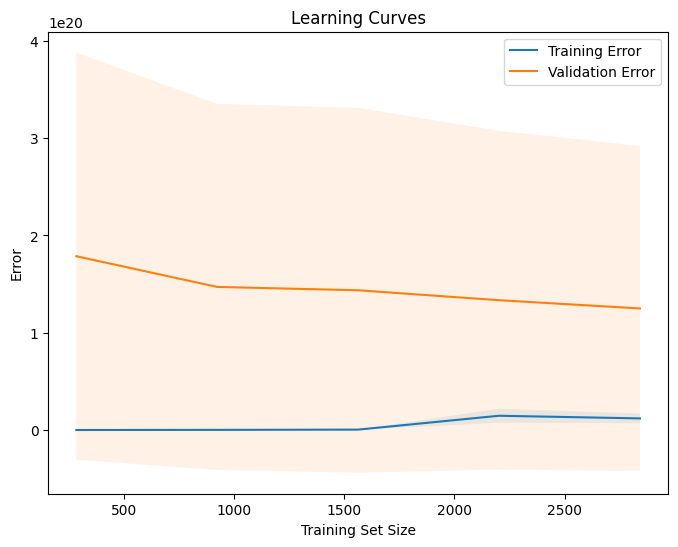

In [32]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(model_rf, X, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
train_mean = -train_scores.mean(axis=1)
test_mean = -test_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
test_std = test_scores.std(axis=1)
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label='Training Error')
plt.plot(train_sizes, test_mean, label='Validation Error')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.title('Learning Curves')
plt.xlabel('Training Set Size')
plt.ylabel('Error')
plt.legend()
plt.show()


Cross-validation results plot

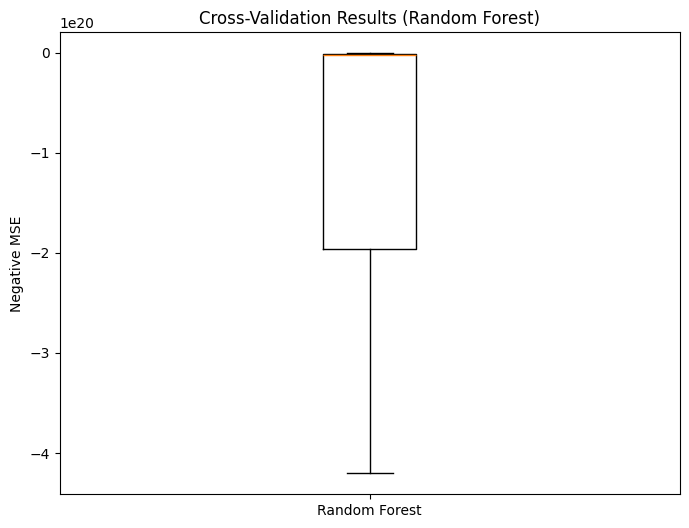

In [33]:
plt.figure(figsize=(8, 6))
plt.boxplot(cv_scores)
plt.title('Cross-Validation Results (Random Forest)')
plt.ylabel('Negative MSE')
plt.xticks([1], ['Random Forest'])
plt.show()


Check Correlation

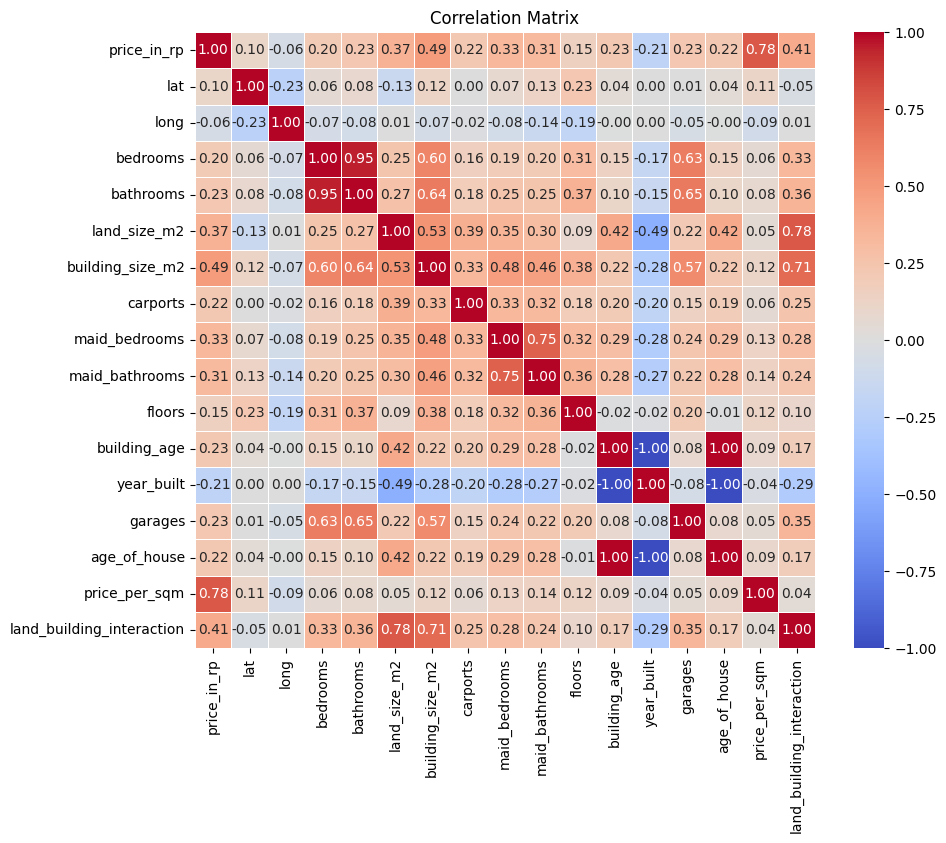

In [36]:
numerical_data = data.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numerical_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


Plot histogram of actual vs predicted prices

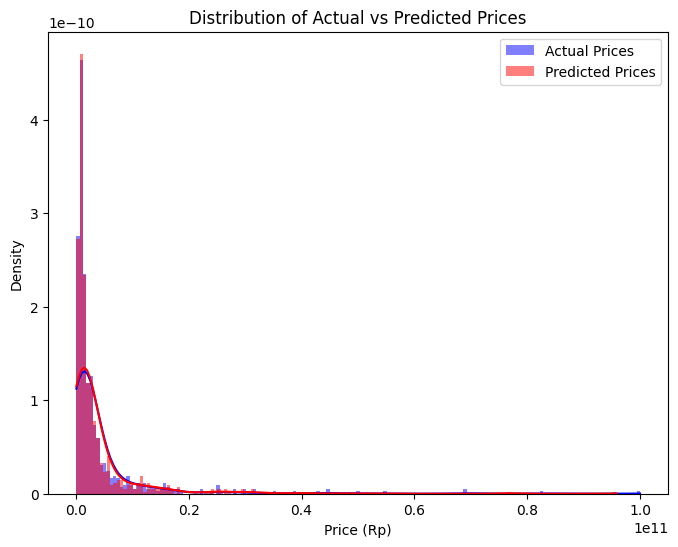

In [37]:
plt.figure(figsize=(8, 6))
sns.histplot(y_test, label='Actual Prices', color='blue', kde=True, stat='density', linewidth=0)
sns.histplot(y_pred_rf, label='Predicted Prices', color='red', kde=True, stat='density', linewidth=0)
plt.legend()
plt.title('Distribution of Actual vs Predicted Prices')
plt.xlabel('Price (Rp)')
plt.ylabel('Density')
plt.show()


<Figure size 1000x600 with 0 Axes>

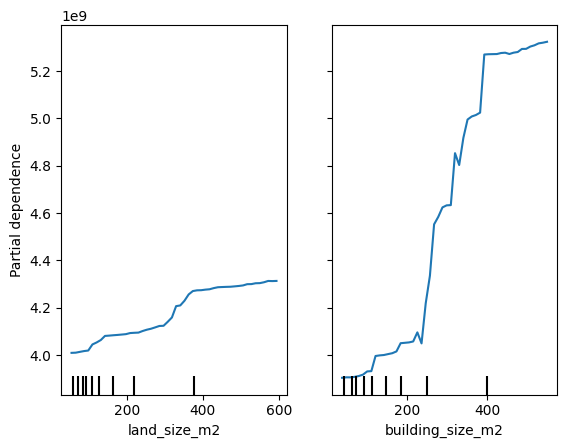

In [39]:
from sklearn.inspection import PartialDependenceDisplay
features = ['land_size_m2', 'building_size_m2']

plt.figure(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(model_rf, X_train, features=features, grid_resolution=50)
plt.show()


In [41]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

rf_model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                           cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)
print(f"Best Parameters: {grid_search.best_params_}")


Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Parameters: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}


In [42]:
best_rf_model = grid_search.best_estimator_
y_pred_rf = best_rf_model.predict(X_test)
from sklearn.metrics import mean_squared_error, r2_score
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Mean Squared Error (MSE) after tuning: {mse_rf}")
print(f"R² Score after tuning: {r2_rf}")


Mean Squared Error (MSE) after tuning: 9.121585795013299e+18
R² Score after tuning: 0.8749422079298056


In [44]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np


param_dist = {
    'n_estimators': np.arange(50, 201, 50),
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

rf_model = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist,
                                   n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                   n_jobs=-1, verbose=2, random_state=42)
random_search.fit(X_train, y_train)
print(f"Best Parameters (Random Search): {random_search.best_params_}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters (Random Search): {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': None}


In [45]:
best_rf_model = random_search.best_estimator_
y_pred_rf = best_rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Mean Squared Error (MSE) after Random Search: {mse_rf}")
print(f"R² Score after Random Search: {r2_rf}")


Mean Squared Error (MSE) after Random Search: 6.007719813208301e+18
R² Score after Random Search: 0.9176336009877879


In [46]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(best_rf_model, X, y, cv=5, scoring='neg_mean_squared_error')
print(f"Cross-Validation MSE (tuned): {-cv_scores.mean()}")


Cross-Validation MSE (tuned): 1.2308588112328702e+20


In [51]:
print("Min Mean Test Score:", grid_search.cv_results_['mean_test_score'].min())
print("Max Mean Test Score:", grid_search.cv_results_['mean_test_score'].max())
print("Mean Mean Test Score:", grid_search.cv_results_['mean_test_score'].mean())


Min Mean Test Score: -1.4152734406354294e+20
Max Mean Test Score: -1.2249274820498267e+20
Mean Mean Test Score: -1.333705481731616e+20


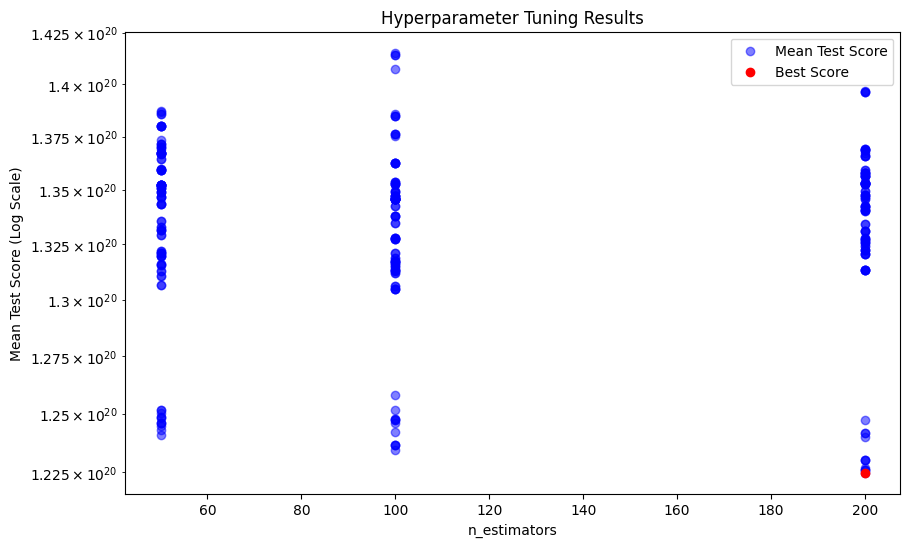

In [52]:
import matplotlib.pyplot as plt
results = grid_search.cv_results_

rescaled_scores = -results['mean_test_score']
plt.figure(figsize=(10, 6))
plt.scatter(results['param_n_estimators'], rescaled_scores, color='blue', label='Mean Test Score', alpha=0.5)
best_index = grid_search.best_index_
best_n_estimators = results['param_n_estimators'][best_index]
best_score = rescaled_scores[best_index]
plt.scatter(best_n_estimators, best_score, color='red', label='Best Score', zorder=5)
plt.yscale('log')

plt.xlabel('n_estimators')
plt.ylabel('Mean Test Score (Log Scale)')
plt.title('Hyperparameter Tuning Results')
plt.legend()
plt.show()
